# Import packages

In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder


# Read files

In [2]:
#read files, join - MUST HAVE FILES IN LOCAL DIRECTORY
train = pd.read_csv("C:/RAHIM/MMA -QUEEN'S/Marketing Analytics - MMA 831/Airbnb/train_users_2.csv")
countries = pd.read_csv("C:/RAHIM/MMA -QUEEN'S/Marketing Analytics - MMA 831/Airbnb/countries.csv")
demographics = pd.read_csv("C:/RAHIM/MMA -QUEEN'S/Marketing Analytics - MMA 831/Airbnb/age_gender_bkts.csv")

# Data cleaning and exploration

In [3]:
#Number of NaN in the dataset
train.isnull().sum()
#date_first_booking is NaN for 124543 users; that makes sense as those are the users who did not book a trip anywhere
#age is NaN for 87990 users; that's not great as that seems like it would be an important variable

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [4]:
#Number of NaN in the dataset
countries.isnull().sum()
#No NA's in country dataset

country_destination              0
lat_destination                  0
lng_destination                  0
distance_km                      0
destination_km2                  0
destination_language             0
language_levenshtein_distance    0
dtype: int64

In [5]:
#Number of NaN in the dataset
demographics.isnull().sum()
#No NA's in demographics dataset

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

In [6]:
#checking what format the dates are in, as they're not in timestamp form (from users.dtypes)
print("Date Account Created","\n", train['date_account_created'].sample(3))
print("\n")
print("Date of First Booking", "\n", train['date_first_booking'].sample(3))

Date Account Created 
 177680    2014-04-19
143827    2014-01-20
192754    2014-05-21
Name: date_account_created, dtype: object


Date of First Booking 
 212000           NaN
27691     2012-06-23
180580    2014-04-28
Name: date_first_booking, dtype: object


In [7]:
#checking what format the dates are in, as they're not in timestamp form (from users.dtypes)
print("Date Account Created","\n", train['date_account_created'].sample(3))
print("\n")
print("Date of First Booking", "\n", train['date_first_booking'].sample(3))

Date Account Created 
 198777    2014-06-03
117418    2013-10-16
127818    2013-11-26
Name: date_account_created, dtype: object


Date of First Booking 
 161274           NaN
209903    2014-07-04
159033    2014-08-18
Name: date_first_booking, dtype: object


In [8]:
#Changing it to date format
train.date_account_created = train.date_account_created.astype('datetime64')
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

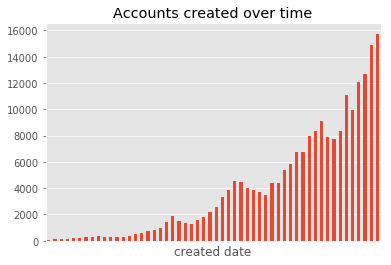

In [9]:
#Accounts created over time - Appendix [4]
train.groupby([train["date_account_created"].dt.year,train["date_account_created"].dt.month,])['id'].count().plot(kind='bar')
plt.xlabel("created date")
plt.title("Accounts created over time")
plt.xticks([])
#plt.savefig("CreatedOverTime")
plt.show()

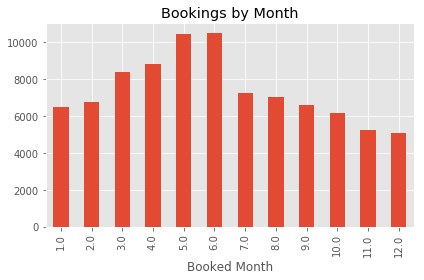

In [10]:
#Bookings by Month - appendix [5]
train.groupby(train["date_first_booking"].dt.month)['id'].count().plot(kind='bar')
plt.xlabel("Booked Month")
plt.title("Bookings by Month")
plt.tight_layout()
plt.savefig("Monthly")
plt.show()

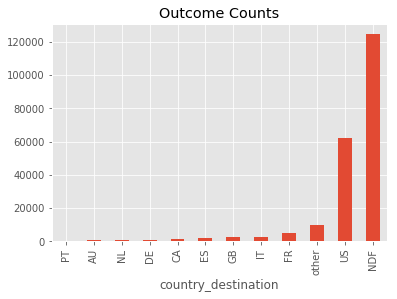

In [11]:
#check baseline for desintation country - Appendix[3]
train.groupby(train["country_destination"])['id'].count().sort_values().plot(kind='bar')
plt.title("Outcome Counts")
#plt.savefig("outcomecoountry")
plt.show()

#which algorithms do best with unbalanced datasets?

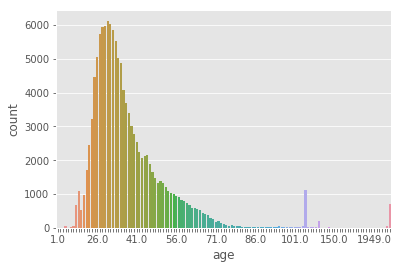

In [12]:
#examining age
train['age'] = train['age'].dropna()

age_plot = sns.countplot(train['age'])

#limiting tick frequency for ease of readability 
for ind, label in enumerate(age_plot.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
#There are few outliers in the data. 100+ and less than 15

In [13]:
#looks like there are ages at 1 and above 100.
train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [14]:
#transform outliers into NaN = <15 and >100

train.loc[train['age'] < 15, 'age'] = np.NaN
train.loc[train['age'] > 100, 'age'] = np.NaN
train['age'].describe()

count    123059.000000
mean         36.559211
std          11.690611
min          15.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64

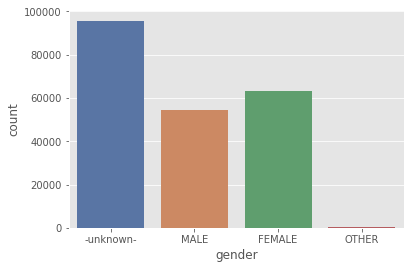

In [15]:
#Lets check the gender
sns.countplot(train['gender'], palette = "deep")

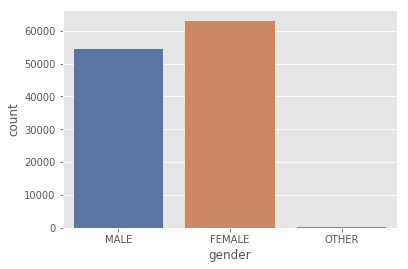

In [16]:
#change unknowns to NaN
train.loc[train['gender'] == '-unknown-', 'gender'] = np.NaN
sns.countplot(train['gender'],  palette = "deep")

In [17]:
#Counting the number of male and female
women = sum(train['gender'] == 'FEMALE')
men = sum(train['gender'] == 'MALE')
print('There are', women, 'women and', men, 'men in this dataset.')

There are 63041 women and 54440 men in this dataset.


In [18]:
#any trend in country destinations in users who put NaN as their gender?

#total number who have NaN genders, and their destinations (proportional)
na_genders = train.loc[train['gender'].isna(), 'country_destination'].value_counts().sum()
na_gender_countries = train.loc[train['gender'].isna(), 'country_destination'].value_counts() / na_genders * 100

#non NaN country destinations (proportional)
complete_genders = train.loc[train['gender'].notnull(), 'country_destination'].value_counts().sum()
complete_gender_countries = train.loc[train['gender'].notnull(), 'country_destination'].value_counts() / complete_genders * 100

compared_na_genders = pd.concat([na_gender_countries, complete_gender_countries], axis = 1)
compared_na_genders.columns = ['na gender countries', 'complete gender countries']
compared_na_genders

#so definitely greater proportion of folks who have NaN as a gender don't book a trip anywhere

,na gender countries,complete gender countries
NDF,69.674358,49.143619
US,21.015174,35.891579
other,3.625324,5.625706
FR,1.790193,2.810730
IT,1.086866,1.524248
GB,0.792158,1.329789
ES,0.747220,1.302616
CA,0.513126,0.795666
DE,0.296798,0.659800
NL,0.237229,0.454302


In [19]:
#Is there an initial trend in where (filled out) genders are going?

#find number of female and male users

female = train.loc[train['gender'] == 'FEMALE', 'country_destination'].value_counts().sum()
male = train.loc[train['gender'] == 'MALE', 'country_destination'].value_counts().sum()

#scale according to total numbers of female and male users

female_destinations = train.loc[train['gender'] == 'FEMALE', 'country_destination'].value_counts() / female * 100
male_destinations = train.loc[train['gender'] == 'MALE', 'country_destination'].value_counts() / male * 100

gender_dest = pd.concat([female_destinations, male_destinations], axis=1)
gender_dest.columns = ['female destinations', 'male destinations']
gender_dest

,female destinations,male destinations
NDF,49.250488,49.079721
US,35.998794,35.740265
other,5.012611,6.324394
FR,3.112260,2.452241
IT,1.730620,1.283982
GB,1.397503,1.252755
ES,1.353088,1.243571
CA,0.721753,0.876194
DE,0.567884,0.764144
NL,0.402912,0.510654


Text(0, 0.5, 'Percentage')

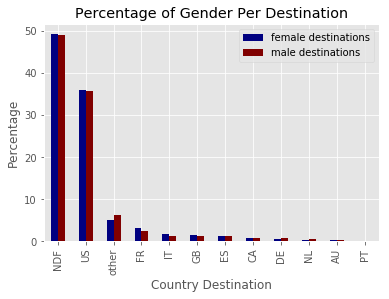

In [20]:
ax = gender_dest.plot.bar(colormap = 'jet', title = 'Percentage of Gender Per Destination')
ax.set_xlabel("Country Destination")
ax.set_ylabel("Percentage")

# Looks just about the same for both groups - nothing stands out here

In [21]:
train.shape

(213451, 16)

# Feature engineering

In [22]:
#Create Age Buckets to add to our onehot encoded data frame

train['Age_Over40'] = (train.age >39).map({True:1,False:0})
train['Age_31-39'] = ((train.age<40) & (train.age>30)).map({True:1,False:0})
train['Age_15-23'] = ((train.age<15) & (train.age>23)).map({True:1,False:0})
train['Age_24-28'] = ((train.age<24) & (train.age>28)).map({True:1,False:0})
train['Age_29-35'] = ((train.age<29) & (train.age>35)).map({True:1,False:0})
train['Age_36-44'] = ((train.age<36) & (train.age>44)).map({True:1,False:0})
train['Age_45-55'] = ((train.age<45) & (train.age>55)).map({True:1,False:0})
train['Age_56-65'] = ((train.age<56) & (train.age>65)).map({True:1,False:0})
train['Age_66-75'] = ((train.age<56) & (train.age>75)).map({True:1,False:0})
train['Age_Under31'] = (train.age <31).map({True:1,False:0})
train['Age_Over75'] = (train.age >75).map({True:1,False:0})
train['Age_unknown'] = (train.age.isnull()).map({True:1,False:0})

In [23]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,Age_15-23,Age_24-28,Age_29-35,Age_36-44,Age_45-55,Age_56-65,Age_66-75,Age_Under31,Age_Over75,Age_unknown
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,NaN,NaN,facebook,0,en,direct,...,0,0,0,0,0,0,0,0,0,1
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(train[f], prefix=f)
    train = train.drop([f], axis=1)
    train = pd.concat((train, df_all_dummy), axis=1)

In [25]:
#train test split dataset to measure performance. Original test_users dataset provided by airbnb does not come with labels
# so we need to create our own test set
x_train,x_test,y_train,y_test = train_test_split(train,train['country_destination'],test_size=0.25,random_state=1)

In [26]:
x_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,age,country_destination,Age_Over40,Age_31-39,Age_15-23,Age_24-28,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
72140,h6nbgzamop,2013-04-21,20130421041349,NaT,NaN,NDF,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77397,ofrl7pgcsc,2013-05-16,20130516035347,NaT,NaN,NDF,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163938,q2ul2nql67,2014-03-16,20140316210524,NaT,NaN,NDF,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129449,ws1fquiwoi,2013-12-03,20131203175838,NaT,NaN,NDF,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25397,ry5b80hmkw,2012-05-25,20120525204442,NaT,47.0,NDF,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modelling

# Random Forest

In [27]:
#Random forest classification - instantiate classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_train.iloc[:,6:164],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
#predict and store predictions in a series 
y_preds_rf = clf.predict(x_test.iloc[:,6:164])

In [29]:
#add the series to our dataframe
x_test['predicted_country'] = y_preds_rf

In [30]:
#import packages used for model evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,f1_score,recall_score
def score(true,pred):
    return(precision_score(true,pred,average='weighted'),
          recall_score(true,pred,average='weighted'),
          f1_score(true,pred,average='weighted'))

In [31]:
#get overall accuracy score for the RF model
RF_all = accuracy_score(x_test['country_destination'],x_test['predicted_country'])
RF_all

0.6218540936604015

In [32]:
#FEATURE SELECTION - check most important features to the random forest algorithm
featureImportance = pd.DataFrame(clf.feature_importances_,x_train.columns[6:164],columns=['feature_importance']).sort_values(["feature_importance"],ascending=False)
featureImportance.head(28)

,feature_importance
Age_unknown,0.156315
signup_method_facebook,0.057382
signup_method_basic,0.048569
gender_FEMALE,0.048165
gender_MALE,0.041351
Age_Under31,0.040307
Age_31-39,0.038196
first_affiliate_tracked_untracked,0.028614
Age_Over40,0.026957
first_affiliate_tracked_linked,0.023876


In [33]:
#split the data again using only the top 25 features
#x_train,x_test,y_train,y_test = train_test_split(x_train.loc[:,list(featureImportance[:25].index)],x_train['country_destination'],test_size=0.25,random_state=1)

In [34]:
#Generate Predictions for RF classifier with 25 features - 61.74%

#clf = RandomForestClassifier()
#clf.fit(x_train,y_train)
#preds = clf.predict(x_test)

In [35]:
#New accuracy score - .4% less in classification, and a simpler model !

#RF = accuracy_score(y_test,preds)
#RF

# Naive Bayes

In [36]:
#import NB package
from sklearn.naive_bayes import BernoulliNB

In [38]:
#Generate predictions using Naive Bayes

clf = BernoulliNB()
clf.fit(x_train.iloc[:,6:164],y_train)
y_preds_NB = clf.predict(x_test.iloc[:,6:164])

In [39]:
#NB accuracy score - 58.67%, lower than baseline - Almost same output with 25 or all features

BNB = accuracy_score(y_test,y_preds_NB)
BNB

0.5867548676048948

# Neural Network

In [41]:
#import NN package

from sklearn.neural_network import MLPClassifier

In [42]:
#Generate prediction using Neural Net

clf = MLPClassifier()
clf.fit(x_train.iloc[:,6:164],y_train)
y_preds_NN = clf.predict(x_test.iloc[:,6:164])

In [43]:
#Neural Network accuracy score - 63.3% with all features.

NN = accuracy_score(y_test,y_preds_NN)
NN

0.6353653280362798

# XGBoost

In [44]:
#import XGBoost package
from xgboost.sklearn import XGBClassifier

In [46]:
#Classifier
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(x_train.iloc[:,6:164], y_train)
y_preds_XGB = xgb.predict(x_test.iloc[:,6:164])  

In [47]:
#XGBoost accuracy score - 63.51% with all features.

XGB = accuracy_score(y_test,y_preds_XGB)
XGB

0.6351779322751719

# Decision Trees

In [48]:
#import DecisionTreeClassifier package
from sklearn.tree import DecisionTreeClassifier

In [49]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=20, min_samples_leaf=20, max_depth=30, max_leaf_nodes=40)
dtc.fit(x_train.iloc[:,6:164], y_train)
y_preds_dtc = dtc.predict(x_test.iloc[:,6:164])  

In [50]:
#DecisionTreeClassifier accuracy score - 63.33% with all features.

DTC = accuracy_score(y_test,y_preds_dtc)
DTC

0.6339411202518599

# KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
#KNN

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(x_train.iloc[:,6:164], y_train)

y_preds_knn = knn_clf.predict(x_test.iloc[:,6:164])

In [56]:
#KNN accuracy score - 55.40% with all features.

KNN = accuracy_score(y_test,y_preds_knn)
KNN

0.5540355677154583

# SVM - Linear

In [57]:
from sklearn.svm import SVC

In [58]:
#SVM

svm_clf = SVC(kernel="linear", C=0.025)
svm_clf.fit(x_train.iloc[:,6:164], y_train)
y_pred_svm = svm_clf.predict(x_test.iloc[:,6:164])

In [59]:
#SVM accuracy score - 63.18% with all features.

SVM = accuracy_score(y_test,y_pred_svm)
SVM

0.6318985064557839

# Model Performance

In [60]:
#Accuracy of each model

pd.DataFrame({'Random Forest':RF_all,'Bernoulli Naive Bayes':BNB,'Neural Network':NN,'XGBoost':XGB,'Decision Trees': DTC,'KNN': KNN,'SVM':SVM,'Baseline':0.55},index=[0])

,Random Forest,Bernoulli Naive Bayes,Neural Network,XGBoost,Decision Trees,KNN,SVM,Baseline
0,0.621854,0.586755,0.635365,0.635178,0.633941,0.554036,0.631899,0.55
